In [1]:
import sys
sys.path.append('../')
import tensorflow as tf
import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from helper import visualize_classification_image_samples, visualize_predictions, visualize_calculate_grid_shape
from helper import fast_benchmark, set_model_config
from helper import plot_loss
from keras import layers
from keras.models import Model
'''Create a random seed generator for randomized TF ops'''
rng = tf.random.Generator.from_seed(123, alg='philox')

2023-12-03 22:09:35.703043: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 22:09:35.703441: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 22:09:35.719263: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 22:09:36.255162: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/stelio/.local/lib/python3.10/site-packages/tqdm/

# Load the Dataset and preview basic info

In [2]:
# Load the Oxford pets
(train_ds, val_ds, test_ds), info = tfds.load(
    'oxford_iiit_pet:3.*.*',
    split=['train+test[:50%]', 'test[50%:80%]', 'test[80%:100%]'],
    with_info=True)

# Access and print dataset information
print("Oxford pets dataset information:")
print(f"Number of classes: {info.features['label'].num_classes}")
print(f"Class names: {info.features['label'].names}")
print(f"Number of training examples: {info.splits['train'].num_examples}")
print(f"Dataset splits: {list(info.splits.keys())}")
print(f"Dataset description: {info.description}")

Oxford pets dataset information:
Number of classes: 37
Class names: ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
Number of training examples: 3680
Dataset splits: ['train', 'test']
Dataset description: The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.


In [10]:
info._features

FeaturesDict({
    'file_name': Text(shape=(), dtype=string),
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
    'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
})

# custom dataloader, shuffling and batching

In [3]:
def p_dataset(image, mask):

    image = tf.image.resize(image , (480,480))
    mask = tf.image.resize(mask, (480,480))
    
    # Random horizontal flip for data augmentation
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    return image, tf.cast(mask, dtype = tf.uint8)
def p_dataset_test(image, mask):
    image = tf.image.resize(image , (480,480))
    mask = tf.image.resize(mask, (480,480))
    return image, mask

def preprocess_data(element):
    image = tf.image.convert_image_dtype(element['image'], tf.float32)
    segmentation_mask = tf.image.convert_image_dtype(element['segmentation_mask'], tf.uint8)
    
    # Apply augmentations
    image, segmentation_mask = p_dataset(image, segmentation_mask)
    
    return image, segmentation_mask

def preprocess_data_test(element):
    image = tf.image.convert_image_dtype(element['image'], tf.float32)
    segmentation_mask = tf.image.convert_image_dtype(element['segmentation_mask'], tf.uint8)
    
    # Apply augmentations
    image, segmentation_mask = p_dataset_test(image, segmentation_mask)
    
    return image, segmentation_mask

batch_size = 32

train_dataset = train_ds.map(preprocess_data)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=32)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

validation_dataset = val_ds.map(preprocess_data_test)
validation_dataset = validation_dataset.batch(batch_size)
validation_dataset = validation_dataset.shuffle(buffer_size=32)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


test_dataset = test_ds.map(preprocess_data_test)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=32)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


# Visualize a few samples from the Dataset

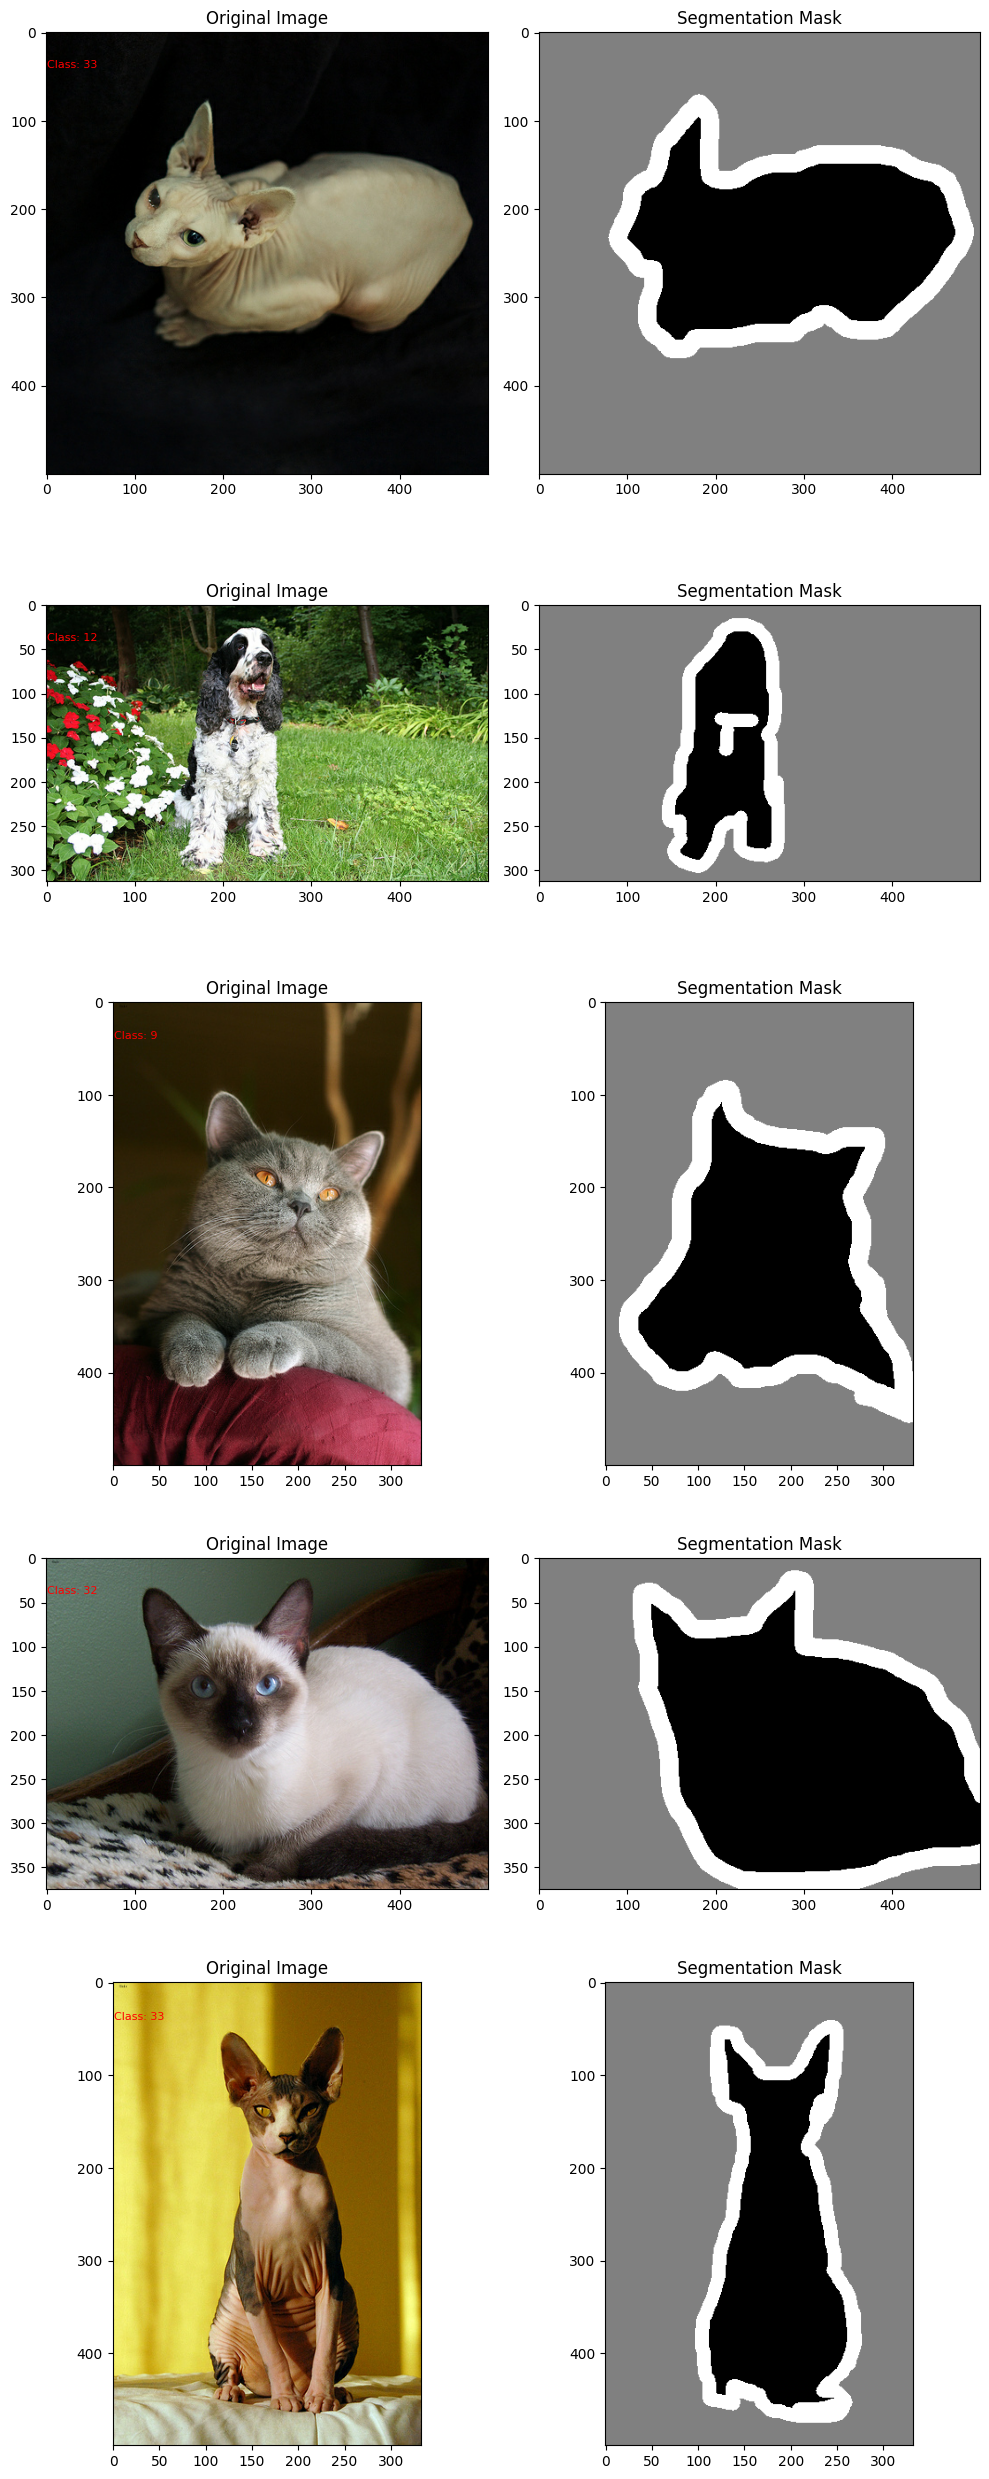

In [3]:
num_samples = 5
# Iterate the dataset 
iterator = iter(train_ds.take(num_samples))
# Create a subplot for displaying images in the grid
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))

for i in range(num_samples):
    batch = next(iterator)   
    image = (batch['image']).numpy().astype(int)  
    # print(image.shape)
    label = (batch['label']).numpy().astype(int)
    segmentation_mask = (batch['segmentation_mask']).numpy().astype(int)
    # print(segmentation_mask.shape)

    # Plot original image
    axes[i,0].imshow(image)
    axes[i,0].set_title('Original Image')
    axes[i,0].text(0.5,+40, f'Class: {label}', fontsize=8, color='red')

    # Plot segmentation mask
    axes[i,1].imshow(segmentation_mask[:, :, 0], cmap='gray')
    axes[i,1].set_title('Segmentation Mask')

plt.tight_layout()
plt.show()


# U-net Architecture

In [4]:
def unet_model(img_size, num_classes):
    inputs = keras.Input(shape = img_size)

    #First half downsamples inputs, and second half upsamples them

    #Downsampling process
    conv1 = layers.Conv2D(64, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(inputs)
    conv1 = layers.Conv2D(64, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(conv1)
    pool1 = layers.MaxPooling2D(pool_size = (2,2))(conv1)
    
    conv2 = layers.Conv2D(128, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(pool1)
    conv2 = layers.Conv2D(128, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(conv2)
    pool2 = layers.MaxPooling2D(pool_size = (2,2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(pool2)
    conv3 = layers.Conv2D(256, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(conv3)
    drop3 = layers.Dropout(0.5)(conv3)
    pool3 = layers.MaxPooling2D(pool_size = (2,2))(drop3)

    conv4 = layers.Conv2D(512, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(pool3)
    conv4 = layers.Conv2D(512, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size = (2,2))(drop4)

    #bottleneck part
    conv5 = layers.Conv2D(1024, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(pool4)
    conv5 = layers.Conv2D(512, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(conv5)

    #Upsampling process with connecting residuals
    up6 = layers.concatenate([layers.Conv2DTranspose(512, (2,2), strides = (2,2), padding = 'same')(conv5), conv4], axis = 3)
    conv6 = layers.Conv2D(256, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(up6)
    conv6 = layers.Conv2D(256, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(conv6)

    up7 = layers.concatenate([layers.Conv2DTranspose(256, (2,2), strides = (2,2), padding = 'same')(conv6), conv3], axis = 3)
    conv7 = layers.Conv2D(128, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(up7)
    conv7 = layers.Conv2D(128, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(conv7)

    up8 = layers.concatenate([layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(conv7), conv2], axis = 3)
    conv8 = layers.Conv2D(64, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(up8)
    conv8 = layers.Conv2D(64, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(conv8)

    up9 = layers.concatenate([layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = 'same')(conv8), conv1], axis = 3)
    conv9 = layers.Conv2D(64, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(up9)
    conv9 = layers.Conv2D(64, 3, activation= 'relu', padding = 'same', kernel_initializer= 'he_normal')(conv9)

    conv10 = layers.Conv2D(1, (1,1), activation = 'sigmoid')(conv9)

    model = keras.models.Model(inputs = [inputs], outputs = [conv10])
    model.compile(optimizer = keras.optimizers.Adam(lr = 0.0001), 
                    loss = tf.keras.losses.BinaryCrossentropy(), 
                    metrics = [tf.keras.metrics.MeanIoU(num_classes = num_classes)])

    return model
    
model = unet_model((480,480,3),info.features['label'].num_classes)

2023-12-03 22:09:56.899996: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9437184 exceeds 10% of free system memory.
2023-12-03 22:09:57.007979: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9437184 exceeds 10% of free system memory.
2023-12-03 22:09:57.014203: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9437184 exceeds 10% of free system memory.
2023-12-03 22:09:57.060812: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18874368 exceeds 10% of free system memory.
2023-12-03 22:09:57.201886: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18874368 exceeds 10% of free system memory.


In [20]:
sample = next(iter(train_dataset))

2023-12-03 22:05:42.906810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:114: Filling up shuffle buffer (this may take a while): 8 of 32
2023-12-03 22:05:55.110182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:114: Filling up shuffle buffer (this may take a while): 23 of 32
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-12-03 22:06:01.326193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


In [21]:
sample[1][0]

<tf.Tensor: shape=(480, 480, 1), dtype=uint8, numpy=
array([[[2],
        [2],
        [2],
        ...,
        [2],
        [2],
        [2]],

       [[2],
        [2],
        [2],
        ...,
        [2],
        [2],
        [2]],

       [[2],
        [2],
        [2],
        ...,
        [2],
        [2],
        [2]],

       ...,

       [[2],
        [2],
        [2],
        ...,
        [2],
        [2],
        [2]],

       [[2],
        [2],
        [2],
        ...,
        [2],
        [2],
        [2]],

       [[2],
        [2],
        [2],
        ...,
        [2],
        [2],
        [2]]], dtype=uint8)>

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 480, 480, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 480, 480, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 480, 480, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 240, 240, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [5]:
num_epochs = 2
model.fit(train_dataset, epochs=num_epochs, validation_data=validation_dataset)

Epoch 1/2


2023-12-03 22:10:23.212107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:20: Filling up shuffle buffer (this may take a while): 22 of 32
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-12-03 22:10:30.767002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


: 